In [1]:
import math
import pulp
import numpy as np
import pandas as pd

In [6]:
dis = np.array(distance)
dis = pd.DataFrame(dis)
dis.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,35,78,76,98,55,52,37,86,88,...,84,78,25,76,21,26,85,62,16,73
1,35,0,60,59,91,81,40,13,84,94,...,91,64,39,102,19,46,79,80,19,39
2,78,60,0,3,37,87,26,48,41,59,...,58,9,58,101,58,64,29,72,65,48
3,76,59,3,0,36,83,24,47,38,56,...,56,7,55,98,56,62,27,68,63,49
4,98,91,37,36,0,84,51,78,17,34,...,36,29,73,90,82,76,13,63,89,85


In [7]:
dis.to_csv("distance.csv",index=False)

In [7]:
np.insert(dis, len(dis), 1000, axis=0)


array([[   0,   35,   78, ...,   62,   16,   73],
       [  35,    0,   60, ...,   80,   19,   39],
       [  78,   60,    0, ...,   72,   65,   48],
       ...,
       [  16,   19,   65, ...,   66,    0,   57],
       [  73,   39,   48, ...,  102,   57,    0],
       [1000, 1000, 1000, ..., 1000, 1000, 1000]])

In [4]:
def makeCVRP():
    num_nodes = 32 #自販機の数
    capacity = 100 #トラックの最大容量
    demand = [ 0, 19, 21, 6, 19, 
               7, 12, 16, 6, 16,
               8, 14, 21, 16, 3,
               22, 18, 19, 1, 24,
               8, 12, 4, 8, 24,
               24, 2, 20, 15, 2,
               14, 9 ] #各自販機の1日あたりの減り(需要)
    coordinate = [] #都市の座標
    coordinate.append( ( 82, 76 ) )
    coordinate.append( ( 96, 44 ) )
    coordinate.append( ( 50, 5 )  )
    coordinate.append( ( 49, 8 )  )
    coordinate.append( ( 13, 7 )  )
    coordinate.append( ( 29, 89 ) )
    coordinate.append( ( 58, 30 ) )
    coordinate.append( ( 84, 39 ) )
    coordinate.append( ( 14, 24 ) )
    coordinate.append( ( 2, 39 )  )
    coordinate.append( ( 3, 82 )  )
    coordinate.append( ( 5, 10 )  )
    coordinate.append( ( 98, 52 ) )
    coordinate.append( ( 84, 25 ) )
    coordinate.append( ( 61, 59 ) )
    coordinate.append( ( 1, 65 )  )
    coordinate.append( ( 88, 51 ) )
    coordinate.append( ( 91, 2 )  )
    coordinate.append( ( 19, 32 ) )
    coordinate.append( ( 93, 3 )  )
    coordinate.append( ( 50, 93 ) )
    coordinate.append( ( 98, 14 ) )
    coordinate.append( ( 5, 42 )  )
    coordinate.append( ( 42, 9 )  )
    coordinate.append( ( 61, 62 ) )
    coordinate.append( ( 9, 97 )  )
    coordinate.append( ( 80, 55 ) )
    coordinate.append( ( 57, 69 ) )
    coordinate.append( ( 23, 15 ) )
    coordinate.append( ( 20, 70 ) )
    coordinate.append( ( 85, 60 ) )
    coordinate.append( ( 98, 5 )  )
    def computeDistance( c1, c2 ): #都市間の距離を計算する関数を定義
        return math.sqrt( pow( c2[0] - c1[0], 2 ) + pow( c2[1] - c1[1], 2 ) )
    distance = [ [ round(computeDistance( c1, c2 )) for c1 in coordinate ] \
                    for c2 in coordinate ]
    return num_nodes, capacity, demand, distance, coordinate


In [5]:
# make problem
num_nodes, capacity, demand, distance, coordinate = makeCVRP()


In [ ]:
coor

In [13]:
# formulate CVRP as integer programming problem
# V = { 0, 1, ..., num_nodes - 1 }, where 0 means the depot
problem = pulp.LpProblem( "CVRP", pulp.LpMinimize )

In [14]:
problem

CVRP:
MINIMIZE
None
VARIABLES

In [17]:
## variables
x = [ [ pulp.LpVariable( 'x_{}_{}'.format( i, j ), cat="Binary" ) \
        if i != j else None for j in range(num_nodes) ] \
        for i in range(num_nodes) ]
u = [ pulp.LpVariable( 'u_{}'.format( i ), demand[i], capacity, cat="Integer" ) \
        for i in range(1,num_nodes) ]

In [18]:
## objective function: \sum_{i \in V}\sum_{j \in V, i!=j} c_ij x_ij
problem += pulp.lpSum( distance[i][j] * x[i][j] for i in range(num_nodes) \
                        for j in range(num_nodes) if i != j )


In [21]:
## constraints:
### \sum_{i \in V\{j}} x_ij = 1 for all j \in V\{0}
for j in range(1,num_nodes):
    problem += pulp.lpSum( x[i][j] for i in range(num_nodes) if i != j ) == 1

In [25]:
### \sum_{j \in V\{i}} x_ij = 1 for all i \in V\{0}
for i in range(1,num_nodes):
    problem += pulp.lpSum( x[i][j] for j in range(num_nodes) if i != j ) == 1

In [26]:
### u_i - u_j + C x_ij <= C - d_j for i, j \in V\{0} i != j such that d_i  + d_j <= C
for i in range(1,num_nodes):
    for j in range(1,num_nodes):
        if i != j and demand[i] + demand[j] <= capacity:
            problem += u[i-1] - u[j-1] + capacity * x[i][j] <= capacity - demand[j]

In [58]:
# solve
threads = 20
maxSeconds = 6000
result = problem.solve(pulp.PULP_CBC_CMD(threads=threads, maxSeconds=maxSeconds))

In [59]:
print("objective value = {}".format(pulp.value(problem.objective)))

objective value = 860.0


860.0

In [60]:
# get edges
edges = [ ( i, j ) for i in range(num_nodes) for j in range(num_nodes)
            if i != j and pulp.value(x[i][j]) == 1 ]

In [61]:
# get paths
paths = []
for i,j in edges:
    if i == 0:
        path = [ i, j ]
        while path[-1] != 0:
            for v, u in edges:
                if v == path[-1]:
                    path.append(u)
                    break
        paths.append(path)

for p in paths:
    print(p)

[0, 14, 6, 2, 3, 4, 11, 28, 23, 0]
[0, 19, 17, 31, 21, 12, 0]
[0, 20, 5, 25, 10, 29, 15, 22, 9, 18, 8, 26, 0]
[0, 27, 24, 0]
[0, 30, 1, 13, 7, 16, 0]


In [62]:
import networkx as nx
import matplotlib.pyplot as plt

In [63]:
# 有向グラフの作成
G = nx.DiGraph()
G.add_edges_from( edges )

color = [ "r", "g", "y", "m", "c" ]
edge_color = []

for i,j in G.edges:
    for t,path in enumerate(paths):
        if i in path and j in path:
            edge_color.append( color[t] )
            break
assert len(edges) == len(edge_color)

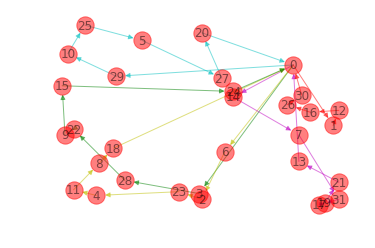

In [57]:
# グラフの描画
pos = { i : coordinate[i] for i in range(num_nodes) }

fig = plt.figure()
nx.draw_networkx( G, pos, edge_color=edge_color, alpha=0.5)
# 表示
plt.axis("off")
fig.savefig("test.png")


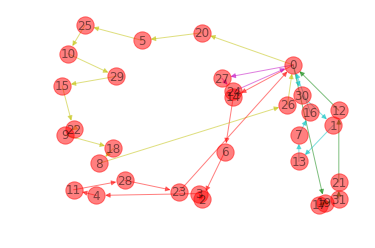

In [64]:
# グラフの描画
pos = { i : coordinate[i] for i in range(num_nodes) }

fig = plt.figure()
nx.draw_networkx( G, pos, edge_color=edge_color, alpha=0.5)
# 表示
plt.axis("off")
fig.savefig("test.png")